## Sentiment classification using tensorflow

- Dataset with cleaned text is chosen.
- Steps followed in this notebook.
    1. Data Importation
    2. Exploratory Data Analysis
    3. Defining the model
    4. Training the model
    5. Model evaluation
    6. Future work

## 1. Data Importation
- Data is imported using pandas and texts are classified into 3 classes (-1: negative, 0: neutral and 1: positive)
- Multi-class classification

In [1]:
#Import Libraries
import pandas as pd
import numpy as np

In [2]:
#Import dataset
df = pd.read_csv('Twitter_Data.csv')
#Drop rows which contains missing values
df = df.dropna()
df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


## 2. Exploratory Data Analysis:
### Basic Statistics of dataset:
Distribution of samples over sentiment indicates more number of samples in positive followed by neutral and negative.

Text(0.5, 1.0, 'Number of samples per sentiment')

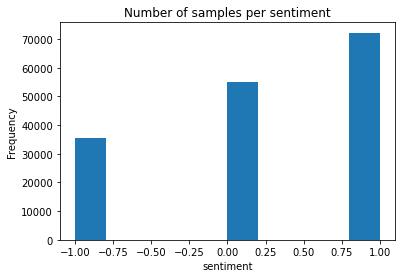

In [3]:
ax = df['category'].plot(kind='hist')
ax.set_xlabel('sentiment')
ax.set_title('Number of samples per sentiment')

### Splitting dataset into training (80%), validation (20%) and test sets (20%):

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.25)
print(train.shape, val.shape, test.shape)

(97781, 2) (32594, 2) (32594, 2)


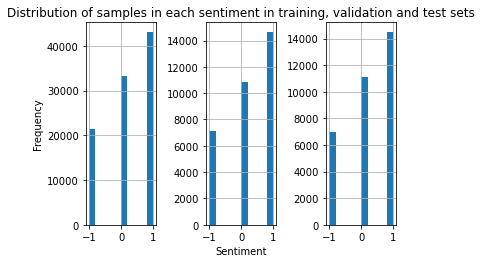

In [5]:
import matplotlib.pyplot as plt
figure = plt.figure()
ax = figure.add_subplot(111)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency', labelpad=20)
ax.set_title('Distribution of samples in each sentiment in training, validation and test sets')

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1 = figure.add_subplot(131)
train['category'].hist(ax=ax1)

ax2 = figure.add_subplot(132)
val['category'].hist(ax=ax2)

ax3 = figure.add_subplot(133)
test['category'].hist(ax=ax3)

plt.tight_layout()
plt.show()

## 3. Defining the model:
### Determining sequence length

Analyzing the sample lengths by plotting a histogram of number of words inorder to standardize the input text length. 
Most of the samples contains 15 words but to have larger coverage (between 50th to 75th), choosing output_sequence_length as 20.

Text(0.5, 1.0, 'Histogram of number of words per sample')

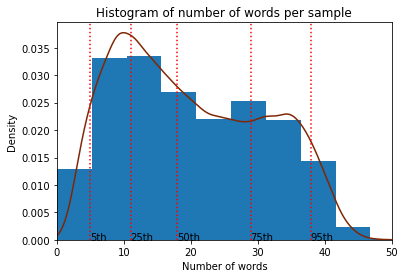

In [6]:
num_words = df['clean_text'].apply(lambda x: len(str(x).split()))

ax = num_words.plot(kind='hist', density=True)
ax = num_words.plot(kind='kde', colormap='Oranges_r')
ax.axvline(num_words.quantile(0.05), linestyle=':', color='red')
ax.text(num_words.quantile(0.05)-.1, 0, "5th")
ax.axvline(num_words.quantile(0.25), linestyle=':', color='red')
ax.text(num_words.quantile(0.25)-.1, 0, "25th")
ax.axvline(num_words.quantile(0.50), linestyle=':', color='red')
ax.text(num_words.quantile(0.50)-.1, 0, "50th")
ax.axvline(num_words.quantile(0.75), linestyle=':', color='red')
ax.text(num_words.quantile(0.75)-.1, 0, "75th")
ax.axvline(num_words.quantile(0.95), linestyle=':', color='red')
ax.text(num_words.quantile(0.95)-.1, 0, "95th")
ax.set_xlim(0,50)
ax.set_xlabel('Number of words')
ax.set_title('Histogram of number of words per sample')

In [7]:
# Defining text vectorization layer to convert the input texts
from tensorflow.keras.layers import TextVectorization
vectorize_layer = TextVectorization(max_tokens = 10000,
                                   standardize = 'lower_and_strip_punctuation',
                                   output_mode = 'int',
                                   output_sequence_length = 20)

In [8]:
#Preparing data (only training data) as list of strings to get it adapt to the vectorization layer
df['clean_text'] = train['clean_text'].apply(lambda x: x.strip())
data = ' '.join(train['clean_text'].to_list())
vectorize_layer.adapt(np.asarray([data]))

In [9]:
#Importing libraries to define the model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
import tensorflow as tf

In [10]:
#Defining simple sequential model with one hiddel layer.
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer) #20 nodes
model.add(Dense(13, activation="relu")) #13 nodes (choosen by the average of input and output nodes)
model.add(Dense(3, activation='softmax')) #3 nodes for 3 outputs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 20)               0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 13)                273       
                                                                 
 dense_1 (Dense)             (None, 3)                 42        
                                                                 
Total params: 315
Trainable params: 315
Non-trainable params: 0
_________________________________________________________________


In [12]:
#Transforming input texts (np array) and output labels (categorical) into format of the model.
from tensorflow.keras.utils import to_categorical

x_train = np.array(train['clean_text'].to_list())
y_train = to_categorical(train['category'], num_classes=3) 
x_val = np.array(val['clean_text'].to_list())
y_val = to_categorical(val['category'], num_classes=3)
x_test = np.array(test['clean_text'].to_list())
y_test = to_categorical(val['category'], num_classes=3)

## 4. Training the model

In [13]:
# Model is traning and fit
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_val, y_val)
)

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]

Epoch 1/10
3056/3056 [==============================] - 13s 4ms/step - loss: 108.6959 - accuracy: 0.3864 - val_loss: 2.2709 - val_accuracy: 0.3953
Epoch 2/10
3056/3056 [==============================] - 12s 4ms/step - loss: 2.3332 - accuracy: 0.3984 - val_loss: 2.6737 - val_accuracy: 0.3780
Epoch 3/10
3056/3056 [==============================] - 13s 4ms/step - loss: 2.0306 - accuracy: 0.4017 - val_loss: 1.6920 - val_accuracy: 0.3608
Epoch 4/10
3056/3056 [==============================] - 12s 4ms/step - loss: 1.7430 - accuracy: 0.4247 - val_loss: 1.7519 - val_accuracy: 0.4132
Epoch 5/10
3056/3056 [==============================] - 13s 4ms/step - loss: 1.6491 - accuracy: 0.4361 - val_loss: 1.6828 - val_accuracy: 0.3920
Epoch 6/10
3056/3056 [==============================] - 12s 4ms/step - loss: 1.5706 - accuracy: 0.4408 - val_loss: 1.6384 - val_accuracy: 0.4028
Epoch 7/10
3056/3056 [==============================] - 12s 4ms/step - loss: 1.4870 - accuracy: 0.4455 - val_loss: 1.3077 - val_

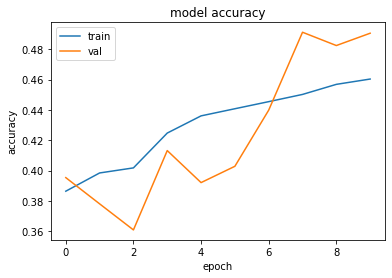

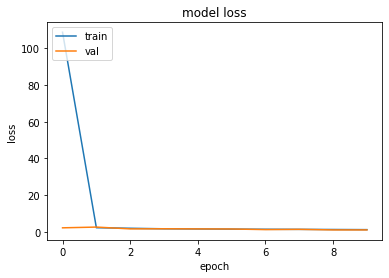

In [14]:
# Plotting the loss and accuracy of train and test sets to see if the model is overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

## 5. Model Evaluation

In [15]:
# Testing the model on test data
score = model.evaluate(x_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1019/1019 [==============================] - 3s 3ms/step - loss: 1.2944 - accuracy: 0.4118
Test Score: 1.2944010496139526
Test Accuracy: 0.4118242561817169


## 6. Future work

**Fine tuning the following features might help to improve the model accuracy:**
1. vocabulary size (max_tokens): Currently chosen vocabulary size is 10,000 but observing the model performance by increasing and decreasing the vocabulary size might help to increase the accuracy.
2. Sequence length : Experimenting with different sequence lengths can also help but ideal to be chosen between 15, 20 and 30 according to the histogram.
3. Word representations (output_mode) : Here, it is taken as 1, but several representations can be tried such as tf-idf and word embeddings.
4. Number of hidden layers : This simple model contains only one hidden layer but adding more hidden layers can help but more complex models might not also perform better.
5. Number of nodes in hidden layers: Choosing number of nodes in hidden layers is quite tricky and experimentation is a way to get to know if there is any major difference in the performance.
6. Types of hidden layers : Different layers such as dense, LSTM and so on can be implemented based on type of the problem. 
7. Optimizer of the model : Different optimizers can be used based on the domain.
8. Number of epochs : Can be used more number of epochs while training the model
**By using these features and making necessary evaluations on these features, model accuracy can be improved.**